In [2]:
from copy import deepcopy
from dataclasses import dataclass
from typing import Optional, List, Tuple
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

from alns import ALNS
from alns.accept import SimulatedAnnealing
from alns.select import AlphaUCB
from alns.stop import MaxIterations, MaxRuntime

# Set random seed for reproducibility
SEED = 2345
rnd.seed(SEED)

@dataclass
class Data:
    n_jobs: int
    n_machines: int
    bkv: int  # best known value
    processing_times: np.ndarray

    @classmethod
    def from_file(cls, path):
        with open(path, "r") as fi:
            lines = fi.readlines()

            n_jobs, n_machines, _, bkv, _ = [
                int(num) for num in lines[1].split()
            ]
            processing_times = np.genfromtxt(lines[3:], dtype=int)

            return cls(n_jobs, n_machines, bkv, processing_times)


def compute_completion_times(schedule):
    """
    Compute the completion time for each job of the passed-in schedule.
    """
    completion = np.zeros(DATA.processing_times.shape, dtype=int)

    for idx, job in enumerate(schedule):
        for machine in range(DATA.n_machines):
            prev_job = completion[machine, schedule[idx - 1]] if idx > 0 else 0
            prev_machine = completion[machine - 1, job] if machine > 0 else 0
            processing = DATA.processing_times[machine, job]

            completion[machine, job] = max(prev_job, prev_machine) + processing

    return completion


def compute_makespan(schedule):
    """
    Returns the makespan, i.e., the maximum completion time.
    """
    return compute_completion_times(schedule)[-1, schedule[-1]]


def plot(schedule, name):
    """
    Plots a Gantt chart of the schedule for the permutation flow shop problem.
    """
    n_machines, n_jobs = DATA.processing_times.shape

    completion = compute_completion_times(schedule)
    start = completion - DATA.processing_times

    # Plot each job using its start and completion time
    cmap = plt.colormaps["rainbow"].resampled(n_jobs)
    machines, length, start_job, job_colors = zip(
        *[
            (i, DATA.processing_times[i, j], start[i, j], cmap(j - 1))
            for i in range(n_machines)
            for j in range(n_jobs)
        ]
    )

    _, ax = plt.subplots(1, figsize=(12, 6))
    ax.barh(machines, length, left=start_job, color=job_colors)

    ax.set_title(f"{name}\n Makespan: {compute_makespan(schedule)}")
    ax.set_ylabel(f"Machine")
    ax.set_xlabel(f"Completion time")
    ax.set_yticks(range(DATA.n_machines))
    ax.set_yticklabels(range(1, DATA.n_machines + 1))
    ax.invert_yaxis()

    plt.show()


class Solution:
    def __init__(
        self, schedule: List[int], unassigned: Optional[List[int]] = None
    ):
        self.schedule = schedule
        self.unassigned = unassigned if unassigned is not None else []

    def objective(self):
        return compute_makespan(self.schedule)

    def insert(self, job: int, idx: int):
        self.schedule.insert(idx, job)

    def opt_insert(self, job: int):
        """
        Optimally insert the job in the current schedule.
        """
        idcs_costs = all_insert_cost(self.schedule, job)
        idx, _ = min(idcs_costs, key=lambda idx_cost: idx_cost[1])
        self.insert(job, idx)

    def remove(self, job: int):
        self.schedule.remove(job)


def all_insert_cost(schedule: List[int], job: int) -> List[Tuple[int, float]]:
    """
    Computes all partial makespans when inserting a job in the schedule.
    O(nm) using Taillard's acceleration. Returns a list of tuples of the
    insertion index and the resulting makespan.

    [1] Taillard, E. (1990). Some efficient heuristic methods for the
    flow shop sequencing problem. European Journal of Operational Research,
    47(1), 65-74.
    """
    k = len(schedule) + 1
    m = DATA.processing_times.shape[0]
    p = DATA.processing_times

    # Earliest completion of schedule[j] on machine i before insertion
    e = np.zeros((m + 1, k))
    for j in range(k - 1):
        for i in range(m):
            e[i, j] = max(e[i, j - 1], e[i - 1, j]) + p[i, schedule[j]]

    # Duration between starting time and final makespan
    q = np.zeros((m + 1, k))
    for j in range(k - 2, -1, -1):
        for i in range(m - 1, -1, -1):
            q[i, j] = max(q[i + 1, j], q[i, j + 1]) + p[i, schedule[j]]

    # Earliest relative completion time
    f = np.zeros((m + 1, k))
    for l in range(k):
        for i in range(m):
            f[i, l] = max(f[i - 1, l], e[i, l - 1]) + p[i, job]

    # Partial makespan; drop the last (dummy) row of q
    M = np.max(f + q, axis=0)

    return [(idx, M[idx]) for idx in np.argsort(M)]


def random_removal(state: Solution, rng, n_remove=2) -> Solution:
    """
    Randomly remove a number jobs from the solution.
    """
    destroyed = deepcopy(state)

    for job in rng.choice(DATA.n_jobs, n_remove, replace=False):
        destroyed.unassigned.append(job)
        destroyed.schedule.remove(job)

    return destroyed


def adjacent_removal(state: Solution, rng, n_remove=2) -> Solution:
    """
    Randomly remove a number adjacent jobs from the solution.
    """
    destroyed = deepcopy(state)

    start = rng.integers(DATA.n_jobs - n_remove)
    jobs_to_remove = [state.schedule[start + idx] for idx in range(n_remove)]

    for job in jobs_to_remove:
        destroyed.unassigned.append(job)
        destroyed.schedule.remove(job)

    return destroyed


def greedy_repair(state: Solution, rng, **kwargs) -> Solution:
    """
    Greedily insert the unassigned jobs back into the schedule. The jobs are
    inserted in non-decreasing order of total processing times.
    """
    state.unassigned.sort(key=lambda j: sum(DATA.processing_times[:, j]))

    while len(state.unassigned) != 0:
        job = state.unassigned.pop()  # largest total processing time first
        state.opt_insert(job)

    return state


def local_search(solution: Solution, **kwargs):
    """
    Improves the current solution in-place using the insertion neighborhood.
    A random job is selected and put in the best new position. This continues
    until relocating any of the jobs does not lead to an improving move.
    """
    improved = True

    while improved:
        improved = False
        current = solution.objective()

        for job in rnd.choice(
            solution.schedule, len(solution.schedule), replace=False
        ):
            solution.remove(job)
            solution.opt_insert(job)

            if solution.objective() < current:
                improved = True
                current = solution.objective()
                break


def greedy_repair_then_local_search(state: Solution, rng, **kwargs):
    """
    Greedily insert the unassigned jobs back into the schedule (using NEH
    ordering). Apply local search afterwards.
    """
    state = greedy_repair(state, rng, **kwargs)
    local_search(state, **kwargs)
    return state


def NEH(processing_times: np.ndarray) -> Solution:
    """
    Schedules jobs in decreasing order of the total processing times.

    [1] Nawaz, M., Enscore Jr, E. E., & Ham, I. (1983). A heuristic algorithm
    for the m-machine, n-job flow-shop sequencing problem. Omega, 11(1), 91-95.
    """
    largest_first = np.argsort(processing_times.sum(axis=0)).tolist()[::-1]
    solution = Solution([largest_first.pop(0)], [])

    for job in largest_first:
        solution.opt_insert(job)

    return solution


In [3]:
def local_search_repair(state: Solution, rng, **kwargs) -> Solution:
    """
    Enhanced repair operator that reinserts unassigned jobs using a local search.
    
    Steps:
      1. Identify the bottleneck machine (with highest total processing time).
      2. Sort unassigned jobs in descending order by their processing time on that machine.
      3. For each unassigned job:
         a. Compute all insertion positions (using Taillard's acceleration via all_insert_cost).
         b. Insert the job at the best position.
         c. Perform a local search (by swapping with neighbors) to check for further improvements.
    """
    # Identify the bottleneck machine (machine with maximum total processing time)
    total_pt = np.sum(DATA.processing_times, axis=1)
    bottleneck = int(np.argmax(total_pt))
    
    # Sort unassigned jobs: those with higher processing time on the bottleneck machine get priority.
    state.unassigned.sort(key=lambda j: DATA.processing_times[bottleneck, j], reverse=True)
    
    # Reinsert each unassigned job
    while state.unassigned:
        # Pop the job with highest priority
        job = state.unassigned.pop(0)
        
        # Get the makespan for all possible insertion positions using Taillard's method.
        insertion_options = all_insert_cost(state.schedule, job)
        best_index, best_cost = min(insertion_options, key=lambda x: x[1])
        
        # Insert the job at the best found position.
        state.schedule.insert(best_index, job)
        
        # --- Local Search Phase ---
        # Try to further improve the schedule by swapping the inserted job with its neighbors.
        improved = True
        while improved:
            improved = False
            current_cost = compute_makespan(state.schedule)
            index = state.schedule.index(job)
            
            # Try moving the job one position to the left.
            if index > 0:
                state.schedule[index], state.schedule[index - 1] = state.schedule[index - 1], state.schedule[index]
                new_cost = compute_makespan(state.schedule)
                if new_cost < current_cost:
                    improved = True
                    current_cost = new_cost  # accept the move
                else:
                    # Revert the swap if no improvement
                    state.schedule[index], state.schedule[index - 1] = state.schedule[index - 1], state.schedule[index]
            
            # Try moving the job one position to the right.
            index = state.schedule.index(job)  # update index (in case it changed)
            if index < len(state.schedule) - 1:
                state.schedule[index], state.schedule[index + 1] = state.schedule[index + 1], state.schedule[index]
                new_cost = compute_makespan(state.schedule)
                if new_cost < current_cost:
                    improved = True
                    current_cost = new_cost
                else:
                    # Revert if no improvement
                    state.schedule[index], state.schedule[index + 1] = state.schedule[index + 1], state.schedule[index]
        # --- End Local Search Phase ---
    
    return state

In [4]:
from copy import deepcopy
from typing import List, Optional, Tuple
import numpy as np
import numpy.random as Generator # Assuming ALNS passes a numpy generator

# -------------------------------------------------------------

def get_critical_path(schedule: List[int]) -> List[int]:
    """
    Trace the critical path in the current schedule.
    Starting from the last machine and the last job,
    move backwards by choosing the predecessor that contributed to
    the completion time (using the recurrence in compute_completion_times).

    Returns a list of unique jobs on the critical path.
    """
    comp = compute_completion_times(schedule)
    m = DATA.n_machines
    k = len(schedule)

    # Handle empty schedule case
    if k == 0:
        return []

    cp_jobs = set()  # to store jobs on the critical path (unique)
    i = m - 1         # start at the last machine
    j = k - 1         # start at the last job in the schedule
    cp_jobs.add(schedule[j])

    # Trace back until we reach the beginning
    while i > 0 or j > 0:
        # Determine the completion time of the current operation (i, j)
        current_comp_time = comp[i, schedule[j]]
        current_proc_time = DATA.processing_times[i, schedule[j]]

        # Check if the bottleneck was the previous job on the same machine
        prev_job_comp = comp[i, schedule[j-1]] if j > 0 else 0
        is_from_prev_job = (j > 0 and current_comp_time == prev_job_comp + current_proc_time)

        # Check if the bottleneck was the same job on the previous machine
        prev_mach_comp = comp[i-1, schedule[j]] if i > 0 else 0
        is_from_prev_mach = (i > 0 and current_comp_time == prev_mach_comp + current_proc_time)

        # Decide which way to move: prioritize moving left if possible and it explains the time
        # If moving left doesn't explain the time, or we can't move left, we must move up.
        if is_from_prev_job and (not is_from_prev_mach or prev_job_comp >= prev_mach_comp):
             j -= 1
        elif is_from_prev_mach: # Must move up if we can
             i -= 1
        elif j > 0: # Fallback if only previous job is possible (e.g., first machine)
             j -= 1
        elif i > 0: # Fallback if only previous machine is possible (e.g., first job)
             i -= 1
        else: # Should not happen if loop condition is correct
            break

        cp_jobs.add(schedule[j]) # Add the job at the new (i, j) position

    return list(cp_jobs)


def critical_destroy(state: Solution, rng: Generator, n_remove: int = 2) -> Solution:
    """
    Destroy operator that removes jobs contributing most to the makespan
    by targeting jobs on the critical path.
    """
    # Create a deep copy so we don't modify the original solution.
    destroyed = deepcopy(state)

    # Handle cases with few jobs in the schedule
    if len(destroyed.schedule) <= n_remove:
        destroyed.unassigned.extend(destroyed.schedule)
        destroyed.schedule = []
        return destroyed

    # Identify the jobs on the critical path.
    cp_jobs = get_critical_path(destroyed.schedule)

    jobs_to_remove = []

    # If there are enough critical jobs, select from them.
    # Optional refinement: sort critical jobs by processing time on the last machine.
    if len(cp_jobs) >= n_remove:
        # Simple random selection from critical path:
        # indices_to_remove = rng.choice(len(cp_jobs), n_remove, replace=False)
        # jobs_to_remove = [cp_jobs[i] for i in indices_to_remove]

        # Refined: Remove critical jobs with highest processing time on last machine
        cp_jobs_sorted = sorted(cp_jobs, key=lambda j: DATA.processing_times[DATA.n_machines - 1, j], reverse=True)
        jobs_to_remove = cp_jobs_sorted[:n_remove]

    else:
        # Otherwise, remove all critical path jobs and then select additional jobs at random.
        jobs_to_remove = cp_jobs.copy()
        remaining_jobs = [j for j in destroyed.schedule if j not in jobs_to_remove]
        # Ensure we don't try to remove more jobs than available
        num_additional_needed = min(n_remove - len(cp_jobs), len(remaining_jobs))
        if num_additional_needed > 0:
             additional = rng.choice(remaining_jobs, num_additional_needed, replace=False)
             jobs_to_remove.extend(additional)

    # Remove the selected jobs from the schedule and add them to the unassigned list.
    for job in jobs_to_remove:
        # Need to handle potential ValueError if job was already removed (e.g. if n_remove > |cp_jobs|)
        if job in destroyed.schedule:
            destroyed.unassigned.append(job)
            destroyed.schedule.remove(job) # Note: remove is O(N), could optimize if needed

    return destroyed

In [5]:
def bottleneck_destroy(state: Solution, rng, n_remove=2) -> Solution:
    """
    Destroy operator that targets jobs with high processing times on bottleneck machines.
    """
    destroyed = deepcopy(state)
    
    # Find the bottleneck machine
    machine_loads = np.sum(DATA.processing_times, axis=1)
    bottleneck_machine = np.argmax(machine_loads)
    
    # Sort and remove jobs with highest processing times on bottleneck
    jobs_sorted = sorted(
        destroyed.schedule, 
        key=lambda j: DATA.processing_times[bottleneck_machine, j],
        reverse=True
    )
    
    for job in jobs_sorted[:n_remove]:
        destroyed.unassigned.append(job)
        destroyed.schedule.remove(job)
    
    return destroyed

def regret_based_repair(state: Solution, rng, **kwargs) -> Solution:
    """
    Repair operator that uses regret-based insertion.
    """
    repaired = deepcopy(state)
    
    while repaired.unassigned:
        max_regret = -1
        best_job = None
        best_position = None
        
        # Calculate regret for each unassigned job
        for job in repaired.unassigned:
            positions_costs = all_insert_cost(repaired.schedule, job)
            positions_costs.sort(key=lambda x: x[1])
            
            # Calculate regret (difference between best and second-best position)
            if len(positions_costs) == 1:
                regret = float('inf')
            else:
                regret = positions_costs[1][1] - positions_costs[0][1]
            
            if regret > max_regret:
                max_regret = regret
                best_job = job
                best_position = positions_costs[0][0]
        
        # Insert job with highest regret
        repaired.unassigned.remove(best_job)
        repaired.schedule.insert(best_position, best_job)
    
    return repaired


Processing instance: tai50_20_02
  Running Baseline...
    Objective: 3777, Gap: 1.67%, Time: 9.88s
  Running Gemini...
    Objective: 3794, Gap: 2.13%, Time: 12.96s
  Running ChatGPT...
    Objective: 3773, Gap: 1.56%, Time: 12.92s


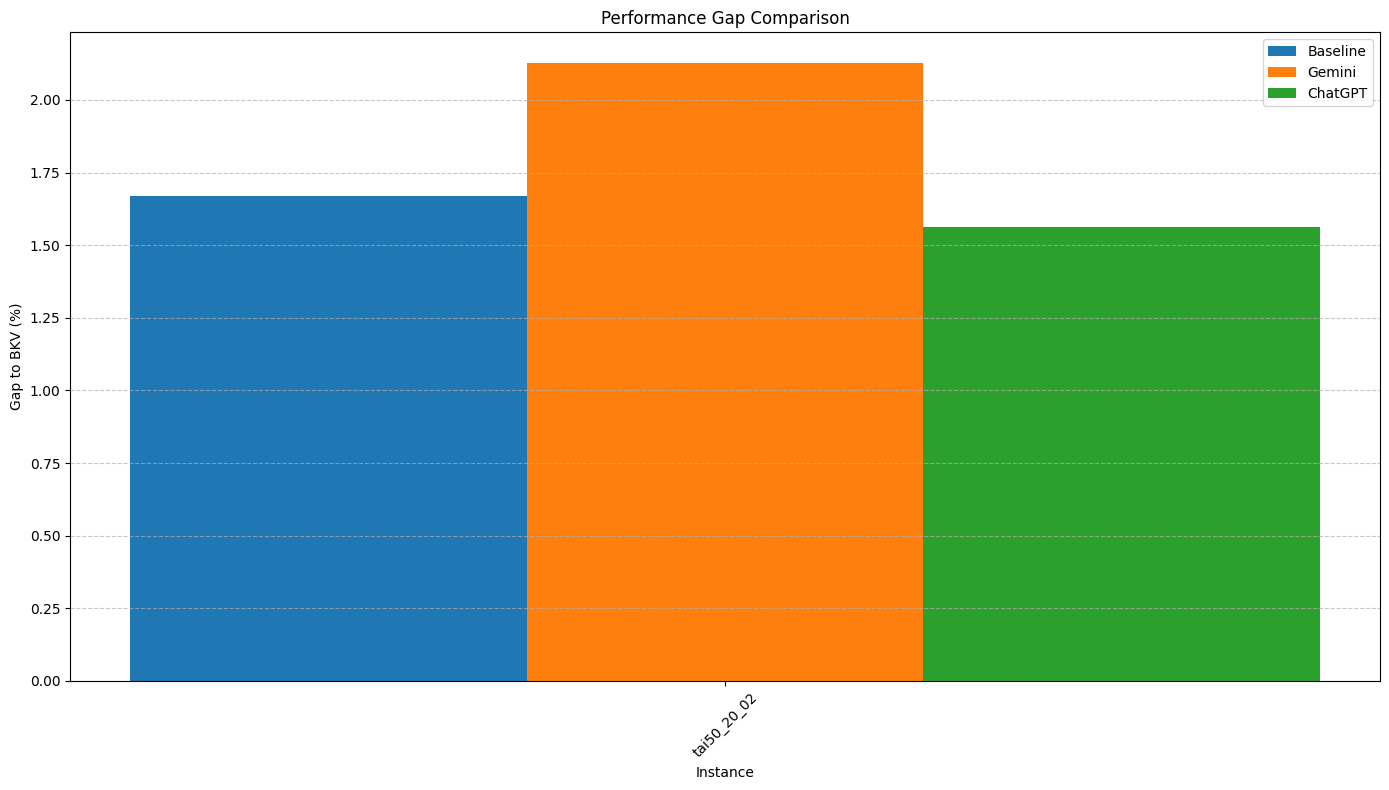

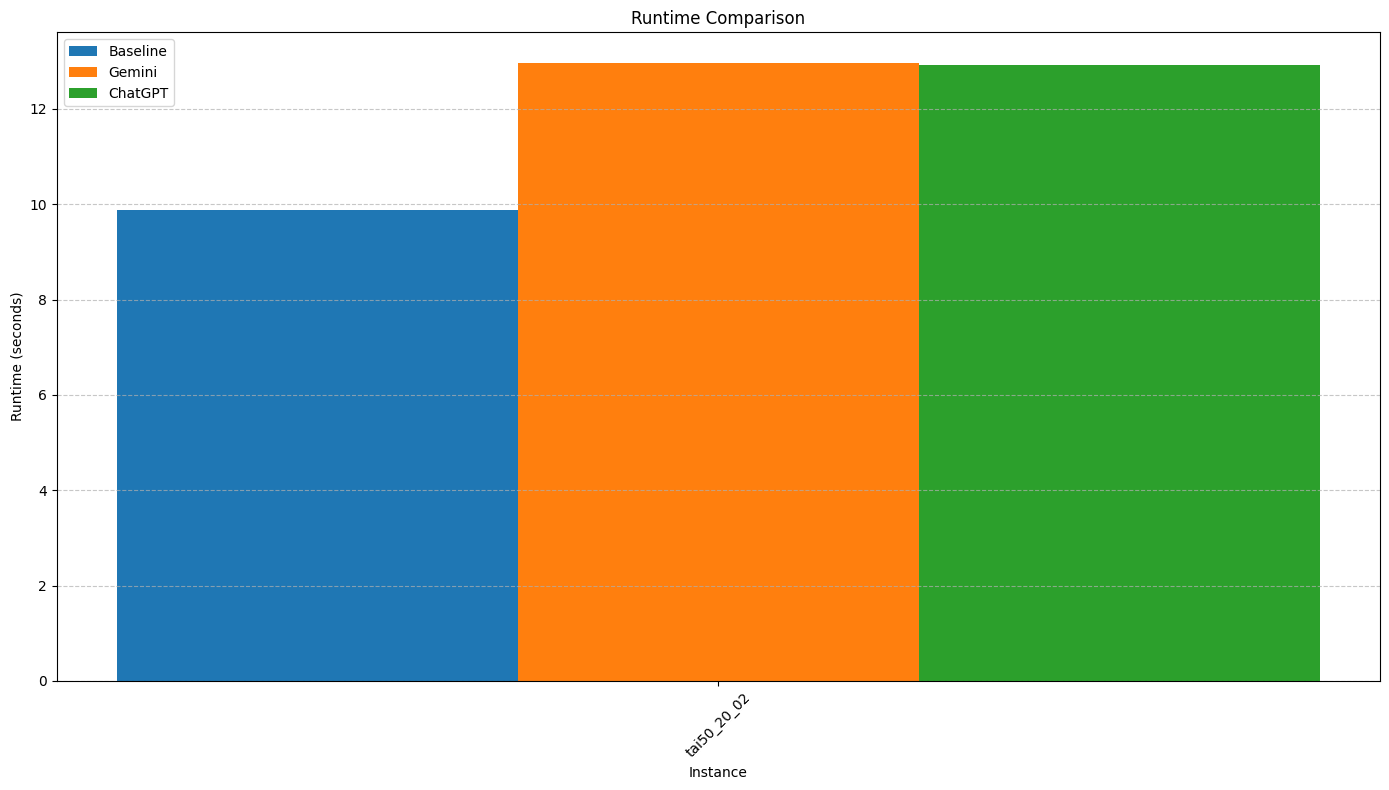

,Approach,Avg Gap (%),Best Gap (%),Worst Gap (%),Avg Time (s)
0,Baseline,1.668910,1.668910,1.668910,9.880567
1,Gemini,2.126514,2.126514,2.126514,12.957606
2,ChatGPT,1.561238,1.561238,1.561238,12.916326


,Instance,Size,BKV,Baseline_Obj,Baseline_Gap,Baseline_Time,Gemini_Obj,Gemini_Gap,Gemini_Time,ChatGPT_Obj,ChatGPT_Gap,ChatGPT_Time
0,tai50_20_02,50x20,3715,3777,1.66891,9.880567,3794,2.126514,12.957606,3773,1.561238,12.916326


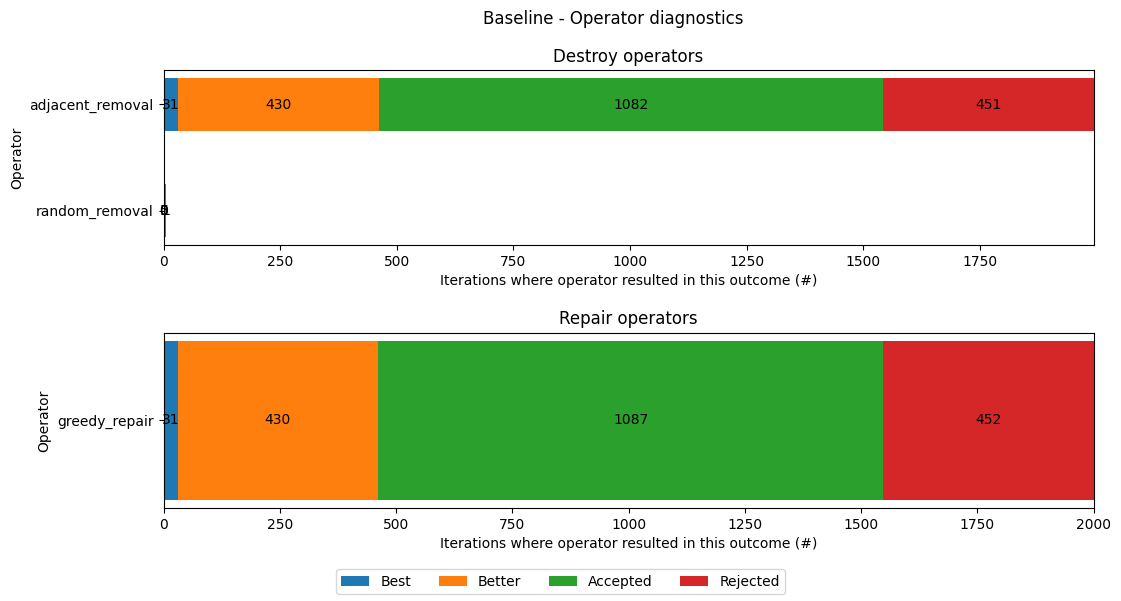

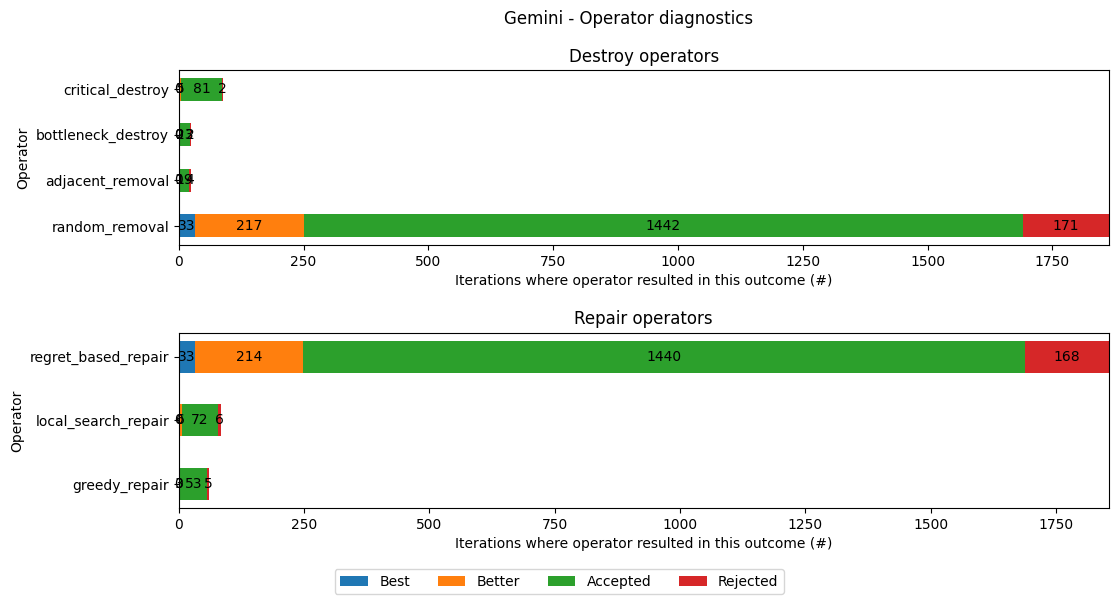

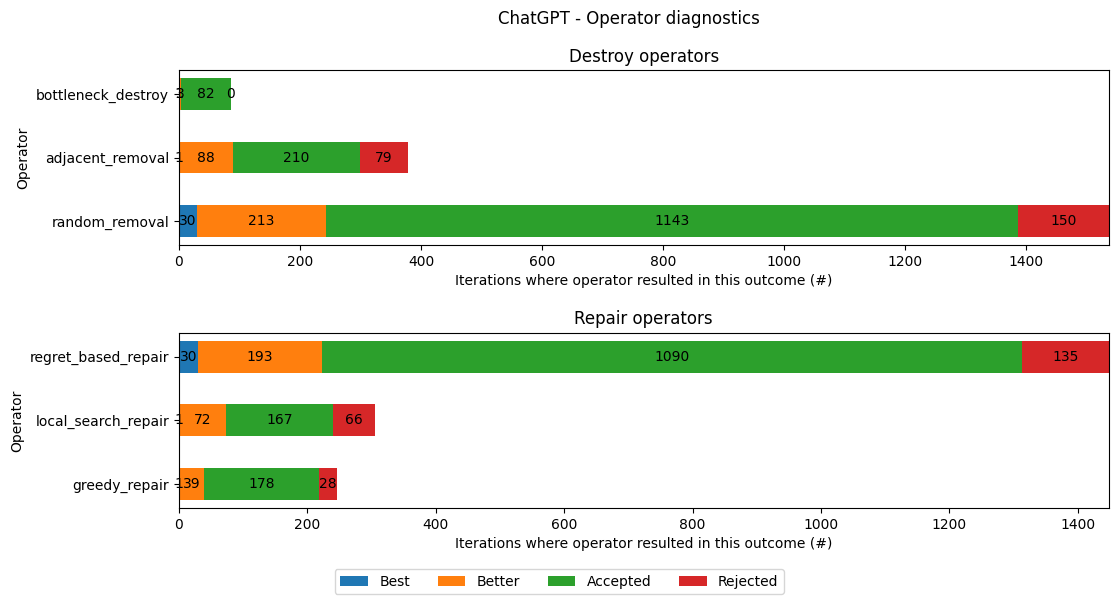

AttributeError: Can't pickle local object 'Statistics.__init__.<locals>.<lambda>'

In [ ]:
def run_benchmark(data_files, approaches, seed=SEED, iters=8000):
    """
    Benchmark different ALNS approaches on multiple problem instances.
    
    Args:
        data_files: List of paths to problem instance files
        approaches: Dictionary mapping approach names to lists of (destroy_ops, repair_ops)
        seed: Random seed for reproducibility
        iters: Number of iterations for each ALNS run
    
    Returns:
        Dictionary containing all benchmark results
    """
    results = {
        'instance_names': [],
        'instance_sizes': [],
        'best_known_values': [],
    }
    
    # Initialize results dictionary for each approach
    for approach_name in approaches:
        results[f'{approach_name}_objectives'] = []
        results[f'{approach_name}_gaps'] = []
        results[f'{approach_name}_times'] = []
        results[f'{approach_name}_results'] = []  # Store the ALNS result objects
    
    for data_file in data_files:
        # Extract instance name from file path
        instance_name = data_file.split('/')[-1].split('.')[0]
        print(f"\nProcessing instance: {instance_name}")
        
        # Load data
        data = Data.from_file(data_file)
        global DATA  # Use global DATA variable for the operators
        DATA = data
        
        results['instance_names'].append(instance_name)
        results['instance_sizes'].append(f"{data.n_jobs}x{data.n_machines}")
        results['best_known_values'].append(data.bkv)
        
        # Create initial solution using NEH
        init = NEH(data.processing_times)
        
        # Run each approach
        for approach_name, (destroy_ops, repair_ops) in approaches.items():
            print(f"  Running {approach_name}...")
            
            # Setup ALNS
            alns = ALNS(rnd.default_rng(seed))
            
            # Add destroy operators
            for destroy_op in destroy_ops:
                alns.add_destroy_operator(destroy_op)
            
            # Add repair operators
            for repair_op in repair_ops:
                alns.add_repair_operator(repair_op)
            
            # Configure ALNS parameters
            select = AlphaUCB(
                scores=[5, 2, 1, 0.5],
                alpha=0.05,
                num_destroy=len(alns.destroy_operators),
                num_repair=len(alns.repair_operators),
            )
            accept = SimulatedAnnealing.autofit(init.objective(), 0.05, 0.50, iters)
            stop = MaxIterations(iters)
            
            # Add time tracking
            time_stop = MaxRuntime(3600)  # 1 hour max runtime
            
            # Run ALNS
            start_time = time.time()
            result = alns.iterate(deepcopy(init), select, accept, stop)
            runtime = time.time() - start_time
            
            # Record results
            objective = result.best_state.objective()
            gap = 100 * (objective - data.bkv) / data.bkv
            
            results[f'{approach_name}_objectives'].append(objective)
            results[f'{approach_name}_gaps'].append(gap)
            results[f'{approach_name}_times'].append(runtime)
            results[f'{approach_name}_results'].append(result)  # Store the ALNS result object
            
            print(f"    Objective: {objective}, Gap: {gap:.2f}%, Time: {runtime:.2f}s")
    
    return results

def visualize_results(results):
    """
    Create visualizations to compare the approaches.
    """
    approach_names = [name.split('_')[0] for name in results.keys() 
                     if name.endswith('_objectives')]
    
    # Create a DataFrame for easier manipulation
    df = pd.DataFrame({
        'Instance': results['instance_names'],
        'Size': results['instance_sizes'],
        'BKV': results['best_known_values']
    })
    
    for approach in approach_names:
        df[f'{approach}_Obj'] = results[f'{approach}_objectives']
        df[f'{approach}_Gap'] = results[f'{approach}_gaps']
        df[f'{approach}_Time'] = results[f'{approach}_times']
    
    # 1. Gap comparison chart
    plt.figure(figsize=(14, 8))
    
    x = np.arange(len(df['Instance']))
    width = 0.8 / len(approach_names)
    
    for i, approach in enumerate(approach_names):
        plt.bar(x + i*width - 0.4 + width/2, df[f'{approach}_Gap'], 
                width=width, label=approach)
    
    plt.xlabel('Instance')
    plt.ylabel('Gap to BKV (%)')
    plt.title('Performance Gap Comparison')
    plt.xticks(x, df['Instance'], rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # 2. Runtime comparison
    plt.figure(figsize=(14, 8))
    
    for i, approach in enumerate(approach_names):
        plt.bar(x + i*width - 0.4 + width/2, df[f'{approach}_Time'], 
                width=width, label=approach)
    
    plt.xlabel('Instance')
    plt.ylabel('Runtime (seconds)')
    plt.title('Runtime Comparison')
    plt.xticks(x, df['Instance'], rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # 3. Summary table
    summary = pd.DataFrame({
        'Approach': approach_names,
        'Avg Gap (%)': [df[f'{approach}_Gap'].mean() for approach in approach_names],
        'Best Gap (%)': [df[f'{approach}_Gap'].min() for approach in approach_names],
        'Worst Gap (%)': [df[f'{approach}_Gap'].max() for approach in approach_names],
        'Avg Time (s)': [df[f'{approach}_Time'].mean() for approach in approach_names],
    })
    
    display(summary)
    
    # 4. Detailed results table
    display(df)
    
    # 5. Operator diagnostics for each approach
    for approach in approach_names:
        if f'{approach}_results' in results and results[f'{approach}_results']:
            # Get the result for the first instance (you can modify this if needed)
            result = results[f'{approach}_results'][0]
            figure = plt.figure(f"{approach}_operator_counts", figsize=(12, 6))
            figure.subplots_adjust(bottom=0.15, hspace=0.5)
            result.plot_operator_counts(figure, title=f"{approach} - Operator diagnostics")
            plt.show()
    
    return df

if __name__ == "__main__":
    import time
    import pandas as pd
    
    # Define the approaches to compare
    approaches = {
        'Baseline': (
            [random_removal, adjacent_removal],  # destroy operators
            [greedy_repair]    # repair operators
        ),
        'Gemini': (
            [random_removal, adjacent_removal, bottleneck_destroy, critical_destroy],  # replace with your custom operators
            [greedy_repair, local_search_repair, regret_based_repair] # replace with your custom operators
        ),
        'ChatGPT': (
            [random_removal, adjacent_removal, bottleneck_destroy],  # replace with your custom operators
            [greedy_repair, local_search_repair, regret_based_repair] # replace with your custom operators
        )
    }
    
    # List all Taillard instances
    data_files = [
        # "data/tai50_20_01.txt",
        "data/tai50_20_02.txt",
        # "data/tai50_20_03.txt",
        # "data/tai50_20_04.txt",
        # "data/tai50_20_05.txt",
        # "data/tai50_20_06.txt",
        # "data/tai50_20_07.txt",
        # "data/tai50_20_08.txt",
        # "data/tai50_20_09.txt",
        # "data/tai50_20_10.txt"
    ]
    
    # Run the benchmark
    results = run_benchmark(data_files, approaches, seed=SEED, iters=2000)
    
    # Visualize and analyze the results
    results_df = visualize_results(results)
    
    # Save results to CSV
    results_df.to_csv('alns_comparison_results.csv', index=False)